# 简单的实时视频内容抓取程序

此例是利用 `SAGE` 和 `CLIP` 模型搭建一个简单的视频内容描述 Pipeline。

**首先**，从下载[视频](https://mixkit.co/free-stock-video/man-riding-a-bicycle-in-a-park-41868/)，1080x720即可。

**然后**，将该文件放到`video_demo.ipynb`所在目录下，开始运行。


## 一、准备环境——导包

In [7]:
# 导入必须的包
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import cv2
import time
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from IPython.display import display, clear_output
from sage.core.api.local_environment import LocalEnvironment
from sage.core.api.function.map_function import MapFunction
from sage.core.api.function.sink_function import SinkFunction
from sage.core.api.function.batch_function import BatchFunction
from sage.common.utils.logging.custom_logger import CustomLogger

## 二、准备 SAGE 算子
### 1. 批处理数据源算子

In [2]:
# 批处理数据源：从视频逐帧读取，如果视频结束，返回 None 终止 Pipeline
class VideoBatch(BatchFunction):
    def __init__(self, video_path):
        super().__init__()
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.frame_delay = 1.0 / self.fps if self.fps > 0 else 0.033
        self.frame_number = 0
    
    def get_fps(self):
        return self.fps
    
    def execute(self):
        if not self.cap.isOpened():
            return None
        ret, frame = self.cap.read()
        if not ret:
            self.cap.release()
            return None
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.frame_number += 1
        return {"frame": frame_rgb, "frame_number": self.frame_number}

### 2. AI 处理算子

In [3]:
# AI视频内容分析器
class VideoAIAnalyzer(MapFunction):
    def __init__(self, analysis_interval=1):
        super().__init__()
        self.analysis_interval = analysis_interval  # 每N帧分析一次
        self.frame_count = 0
        self.last_description = "视频开始播放..."
        self.description_cache = {}
        
        try:
            # 使用轻量级的CLIP模型
            model_name = "openai/clip-vit-base-patch32" 
            self.device = "cuda" if torch.cuda.is_available() else "cpu" 
            self.model = CLIPModel.from_pretrained(model_name).to(self.device) 
            self.processor = CLIPProcessor.from_pretrained(model_name)
                
            # 预定义的场景描述模板
            self.scene_templates = [
                "A person riding a bicycle",
                "A person exercising in a park",
                "Outdoor activity scenes",
                "A person walking on the street",
                "Sports and fitness activities",
                "Leisure time",
                "Activities in green environments",
                "Using transportation",
                "Everyday life scenes",
                "Healthy lifestyle"
            ]
            
        except Exception as e:
            print(f"AI模型加载失败: {e}")
            self.model = None
            self.processor = None   
            
    def analyze_frame_with_ai(self, frame):
        """使用CLIP模型分析帧内容"""
        
        try:
            # 转换为PIL图像
            pil_image = Image.fromarray(frame)
            
            # 使用CLIP进行零样本分类
            inputs = self.processor(
                text=self.scene_templates, 
                images=pil_image, 
                return_tensors="pt", 
                padding=True
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                logits_per_image = outputs.logits_per_image
                probs = logits_per_image.softmax(dim=1)
            
            # 获取最可能的描述
            max_prob_idx = probs.argmax().item()
            confidence = probs[0][max_prob_idx].item()
            
            best_description = self.scene_templates[max_prob_idx]
            
            # 如果置信度较低，返回通用描述
            if confidence < 0.3:
                return f"Video (confidence: {confidence:.2f})"
            else:
                return f"{best_description} (confidence: {confidence:.2f})"
                
        except Exception as e:
            return f"AI分析出错: {str(e)}..."
    
    def execute(self, data):
        if data is None:
            return data
        
        frame = data["frame"]
        frame_number = data["frame_number"]
        self.frame_count += 1
        
        # 定期进行AI分析
        if self.frame_count % self.analysis_interval == 0:

            description = self.analyze_frame_with_ai(frame)
            self.last_description = description
            # 缓存描述避免重复计算
            self.description_cache[frame_number] = description
        else:
            # 简单的基于帧数的描述（无AI时的fallback）
            timestamp = frame_number / 30.0  # 假设30fps
            self.last_description = f"Playback time: {timestamp:.1f} seconds - Video content analysis..."
        
        # 返回带有描述的数据
        data["ai_description"] = self.last_description
        data["analysis_confidence"] = "AI"
        return data

### 3. 视频显示算子

In [4]:
# 增强的显示器，包含AI描述
class AIEnhancedJupyterSink(SinkFunction):
    def __init__(self, video_fps=None, figsize=(12, 8), **kwargs):
        super().__init__(**kwargs)
        self.video_fps = video_fps or 30
        self.target_frame_time = 1.0 / self.video_fps
        
        # 创建subplot布局
        plt.ioff()
        self.fig = plt.figure(figsize=figsize, facecolor='black')
        
        # 视频显示区域
        self.ax_video = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        self.ax_video.set_facecolor('black')
        self.ax_video.axis('off')
        
        # AI描述文本区域
        self.ax_text = plt.subplot2grid((3, 1), (2, 0))
        self.ax_text.set_facecolor('black')
        self.ax_text.axis('off')
        
        self.im = None
        self.frame_count = 0
        self.last_frame_time = time.time()
        
        # 文本对象
        self.title_text = self.ax_video.text(0.5, 0.95, '', transform=self.ax_video.transAxes, 
                                           ha='center', va='top', color='white', fontsize=12)
        
        self.description_text = self.ax_text.text(0.05, 0.5, '', transform=self.ax_text.transAxes,
                                                ha='left', va='center', color='lightgreen', 
                                                fontsize=11, wrap=True, weight='bold')
        
        self.confidence_text = self.ax_text.text(0.95, 0.1, '', transform=self.ax_text.transAxes,
                                               ha='right', va='bottom', color='orange', 
                                               fontsize=9)
        
        plt.tight_layout()
        
    def execute(self, data):
        if data is None:
            return
        
        frame = data["frame"]
        frame_number = data["frame_number"]
        ai_description = data.get("ai_description", "Analyzing...")
        confidence_info = data.get("analysis_confidence", "")
        
        current_time = time.time()
        elapsed = current_time - self.last_frame_time
        
        # 更新视频显示
        if self.im is None:
            self.im = self.ax_video.imshow(frame, aspect='equal', interpolation='bilinear')
        else:
            self.im.set_array(frame)
        
        # 更新文本信息
        self.frame_count += 1
        fps_actual = 1.0 / (elapsed * 1000) if elapsed > 0 else 0
        
        self.title_text.set_text(f'Ping: {frame_number} | FPS: {fps_actual:.1f} | Target FPS: {self.video_fps:.1f}')
        
        # 格式化AI描述
        wrapped_description = self.wrap_text(ai_description, 60)
        self.description_text.set_text(f"AI Discription: {wrapped_description}")
        self.confidence_text.set_text(f"Engine: {confidence_info}")
        
        # 显示更新
        clear_output(wait=True)
        display(self.fig)
        
        # 帧率控制
        processing_time = time.time() - current_time
        sleep_time = max(0, self.target_frame_time - processing_time)
        
        if sleep_time > 0:
            time.sleep(sleep_time * 0.9)
        
        self.last_frame_time = time.time()
    
    def wrap_text(self, text, width):
        """简单的文本换行"""
        words = text.split(' ')
        lines = []
        current_line = []
        current_length = 0
        
        for word in words:
            if current_length + len(word) + 1 <= width:
                current_line.append(word)
                current_length += len(word) + 1
            else:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
        
        if current_line:
            lines.append(' '.join(current_line))
        
        return '\n'.join(lines)

In [5]:
def main():
    env = LocalEnvironment("AI_Video_Analysis")
    video_path = "mixkit-man-riding-a-bicycle-in-a-park-41868-hd-ready.mp4"

    # 获取视频信息
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps if original_fps > 0 else 0
    cap.release()

    # 构建处理管道（简化版，无ProcessFunction）
    env.from_batch(VideoBatch, video_path=video_path).map(VideoAIAnalyzer).sink(AIEnhancedJupyterSink, video_fps=original_fps)
    start_time = time.time()
    env.submit(autostop=True)
    actual_time = time.time() - start_time

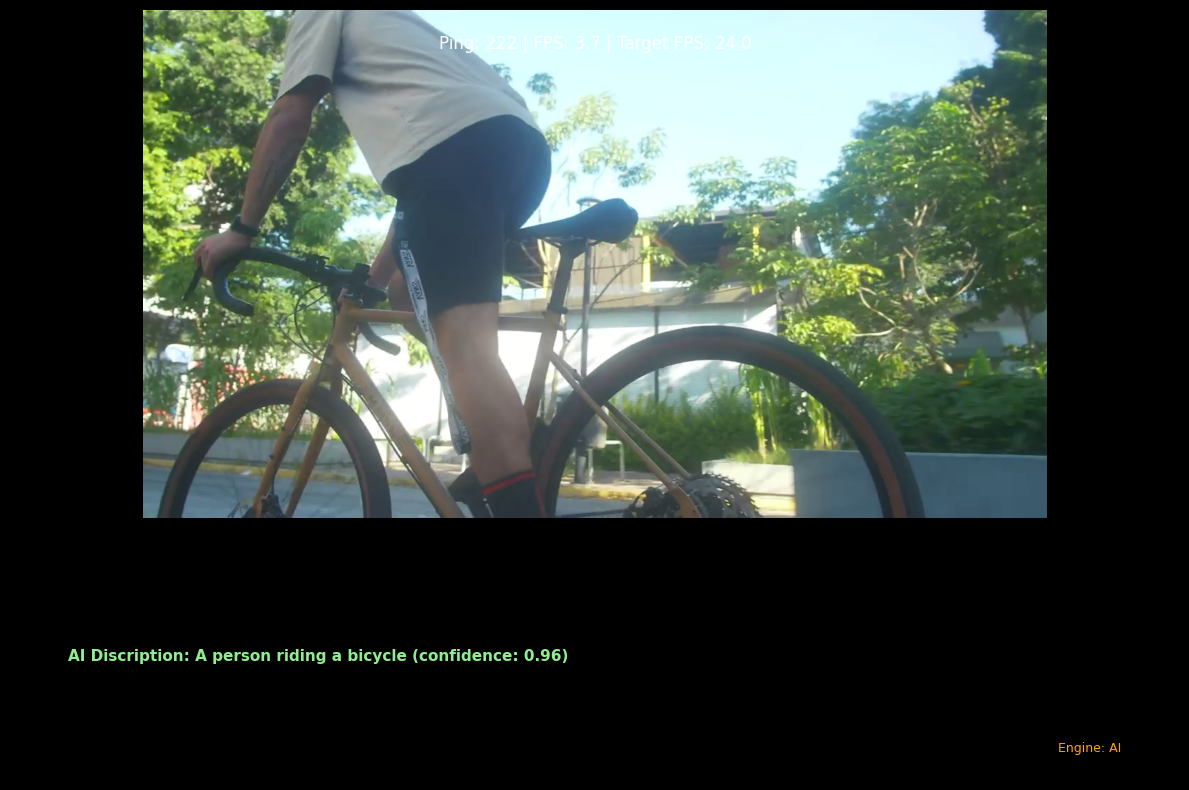

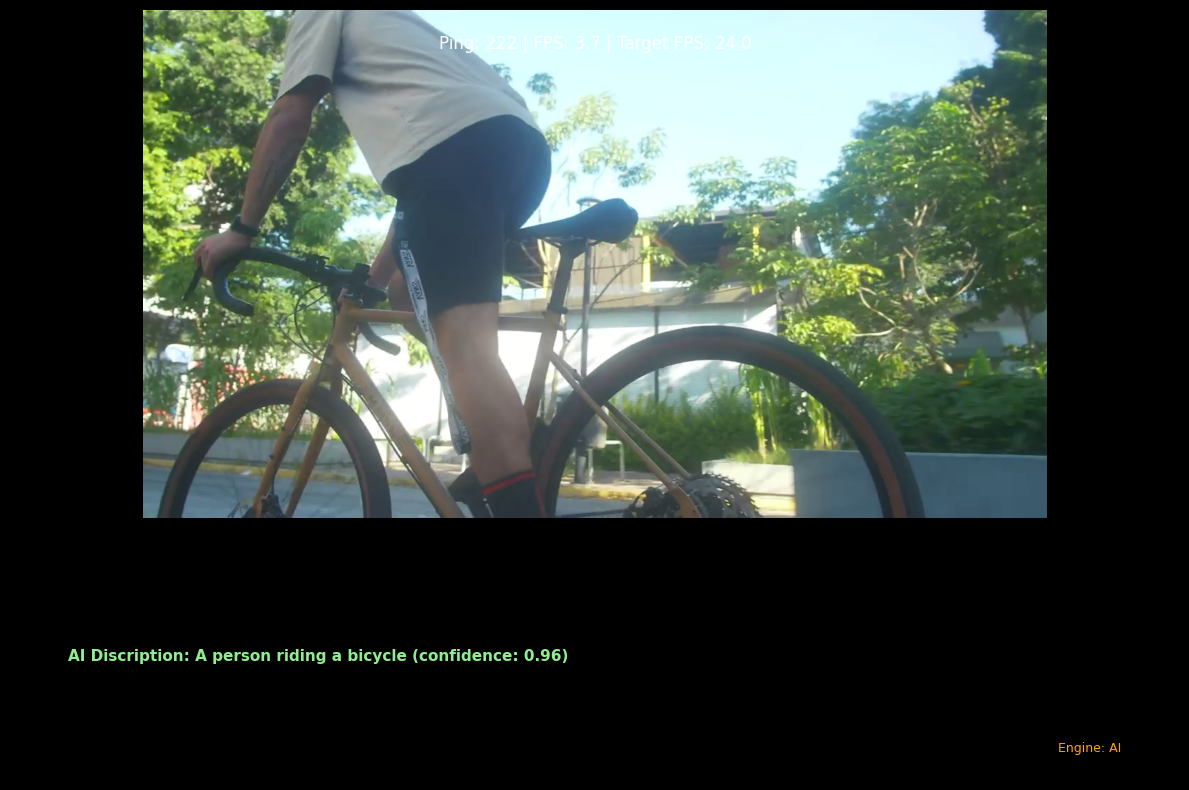

In [6]:
if __name__ == "__main__":
    CustomLogger.disable_global_console_debug()
    main()